In [1]:
import torch
import torchvision
from torchvision import transforms

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.datasets import VisionDataset

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import json
import os
import shutil
import glob
#!pip install pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [3]:
class CocoDatasetFilter:
    def __init__(self, annotations_file, images_dir):
        self.coco = COCO(annotations_file)
        self.images_dir = images_dir

    def filter_dataset(self, categories_to_keep, output_dir, sample):
        # Get the category IDs and names
        cat_ids = self.coco.getCatIds()
        cat_names = [self.coco.loadCats(ids)[0]['name'] for ids in cat_ids]

        # Get the category IDs to keep
        cat_ids_to_keep = [cat_ids[cat_names.index(name)] for name in categories_to_keep]

        # Create a new directory for the filtered dataset
        os.makedirs(output_dir, exist_ok=True)

        # Create a new COCO dataset with the filtered categories
        filtered_coco = COCO()
        filtered_coco.dataset['categories'] = [{'id': i, 'name': cat_names[cat_ids.index(cat_id)]} for i, cat_id in enumerate(cat_ids_to_keep)]
        filtered_coco.dataset['images'] = []  # Initialize 'images' list
        filtered_coco.dataset['annotations'] = []  # Initialize 'annotations' list

        # Iterate over images
        img_ids = random.sample(self.coco.getImgIds(), sample)
        for img_id in img_ids:
            # Load the image
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.images_dir, img_info['file_name'])

            # Get the annotations for the current image
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
  
            # Check if the image has any annotations from the categories to keep
            keep_img = any(ann['category_id'] in cat_ids_to_keep for ann in anns)

            if keep_img:
                # Copy the image to the filtered dataset directory
                filtered_img_path = os.path.join(output_dir, img_info['file_name'])
                shutil.copy(img_path, filtered_img_path)

                # Add the image and annotations to the filtered COCO dataset
                filtered_coco.dataset['images'].append(img_info)
                filtered_anns = [ann for ann in anns if ann['category_id'] in cat_ids_to_keep]
                for ann in filtered_anns:
                    ann['category_id'] = cat_ids_to_keep.index(ann['category_id'])
                filtered_coco.dataset['annotations'].extend(filtered_anns)

        # Save the filtered COCO dataset
        filtered_coco_path = os.path.join(output_dir, 'annotations_coco.json')
        with open(filtered_coco_path, 'w') as f:
            json.dump(filtered_coco.dataset, f)

In [4]:
# filter dataset
sample = 10

def filter_coco_dataset_splits(root, folder, categories_to_keep, sample):
    # Get the list of annotation files matching the pattern
    annotations_file = glob.glob(os.path.join(root, folder,'*.json'))[0]
    
    images_dir = os.path.join(root, folder)
    output_dir = os.path.join('filtered_dataset', folder)
    
    dataset_filter = CocoDatasetFilter(annotations_file, images_dir)
    dataset_filter.filter_dataset(categories_to_keep, output_dir, sample)

categories_to_keep = ['Person', 'gloves', 'helmet', 'mask', 'no-gloves', 'no-helmet', 'no-mask', 'no-shoes', 'no-vest', 'shoes', 'vest']

#filter_coco_dataset_splits('dataset', 'train', categories_to_keep, sample)
#filter_coco_dataset_splits('dataset', 'test', categories_to_keep, sample)   
#filter_coco_dataset_splits('dataset', 'valid', categories_to_keep, sample)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


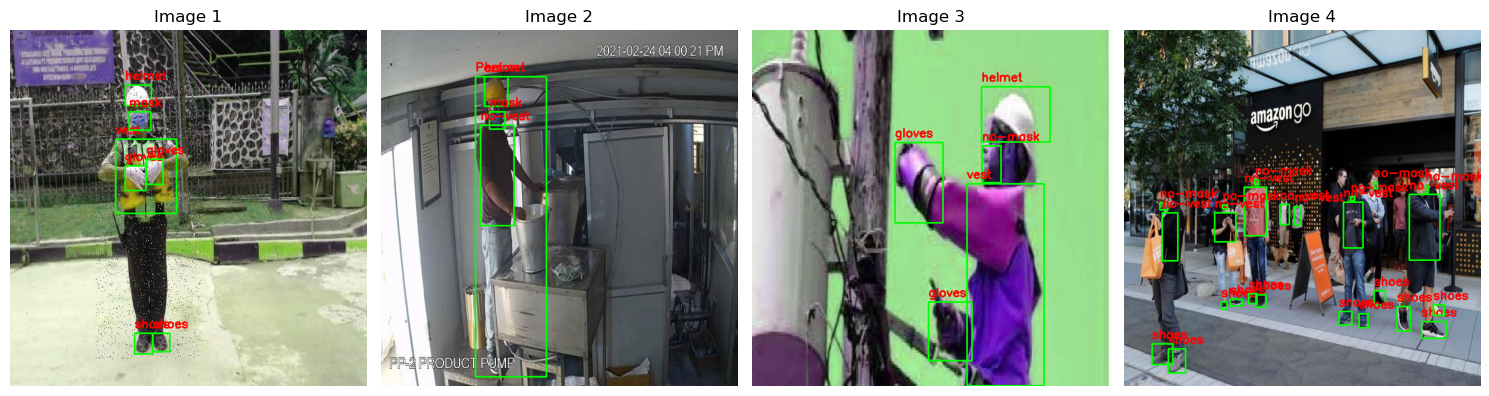

In [5]:
# Load the COCO annotations to plot examples

root_dataset='filtered_dataset'
folder_dataset='train'

annotations_file = glob.glob(os.path.join(root_dataset, folder_dataset,'*.json'))[0]
images_dir = os.path.join(root_dataset, folder_dataset)

coco = COCO(annotations_file)

# Get the category IDs and names
cat_ids = coco.getCatIds()
cat_names = [coco.loadCats(ids)[0]['name'] for ids in cat_ids]

# Get a list of all image IDs
img_ids = coco.getImgIds()

# Select 6 random image IDs
random_img_ids = random.sample(img_ids, 4)

# Create a figure with 6 subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs = axs.ravel()

# Iterate over the random image IDs
for i, img_id in enumerate(random_img_ids):
    # Load the image
    img_info = coco.loadImgs(img_id)[0]
    img_path = images_dir + '/' + img_info['file_name']

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get the annotations for the current image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Iterate over annotations
    for ann in anns:
        # Get the bounding box coordinates
        bbox = ann['bbox']
        x, y, w, h = [int(v) for v in bbox]

        # Get the category ID and name
        cat_id = ann['category_id']
        cat_name = cat_names[cat_ids.index(cat_id)]

        # Draw the bounding box and label on the image
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green color for bounding box
        cv2.putText(img, cat_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2) # Red color for label

    # Plot the image with bounding boxes
    axs[i].imshow(img)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Training

In [6]:
# Load a pre-trained model for transfer learning
weights=torchvision.models.ResNet50_Weights.DEFAULT
backbone = resnet_fpn_backbone(backbone_name='resnet50', weights=weights)
#model = FasterRCNN(backbone=backbone, num_classes=91)

# Freeze the backbone layers
for param in backbone.body.parameters():
    param.requires_grad = False

# Modify the model for custom classes
num_classes = len(cat_ids)  # number of custom classes
model = FasterRCNN(backbone=backbone, num_classes=num_classes + 1)  # +1 for the background class

In [7]:
# Get the number of input features for the classifier
num_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(num_features, num_classes=num_classes + 1)
print(num_features)

1024


In [8]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
# Print with torchinfo
from torchinfo import summary
#!pip install torchinfo

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
FasterRCNN (FasterRCNN)                                 [1, 3, 224, 224]     [100, 4]             --                   Partial
├─GeneralizedRCNNTransform (transform)                  [1, 3, 224, 224]     [1, 3, 800, 800]     --                   --
├─BackboneWithFPN (backbone)                            [1, 3, 800, 800]     [1, 256, 13, 13]     --                   Partial
│    └─IntermediateLayerGetter (body)                   [1, 3, 800, 800]     [1, 2048, 25, 25]    --                   False
│    │    └─Conv2d (conv1)                              [1, 3, 800, 800]     [1, 64, 400, 400]    (9,408)              False
│    │    └─FrozenBatchNorm2d (bn1)                     [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --
│    │    └─ReLU (relu)                                 [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --
│

In [10]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import glob
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CustomCOCODataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        image_path = os.path.join(self.root, self.coco.loadImgs(img_id)[0]['file_name'])
        image = np.array(Image.open(image_path).convert("RGB"))  # Convert PIL image to NumPy array
        
        # Extract bounding boxes and labels
        boxes = []
        labels = []
        for ann in anns:
            # Convert COCO format bounding box to x_min, y_min, x_max, y_max format
            x, y, w, h = ann['bbox']
            x_min, y_min, x_max, y_max = x, y, x + w, y + h
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann['category_id'])
        

        
        # Apply transformations using Albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']
        
        # Resize target
        if self.transforms is not None:
            image_size = image.shape[1], image.shape[2]  # (height, width)
            target = {'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels)}
        
        return image, target

# Define Albumentations transforms
transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


/home/hellraiser/.local/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, json-or-python[json=list[float], python=list[float]]]` but got `tuple` - serialized value may not be as expected
  Expected `Union[float, json-or-python[json=list[float], python=list[float]]]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [11]:
# Define dataset and dataloader
root_dataset = 'filtered_dataset'
folder_train = 'train'
folder_val = 'valid'

image_train = os.path.join(root_dataset, folder_train)
annotations_train = glob.glob(os.path.join(image_train, '*.json'))[0]

image_val = os.path.join(root_dataset, folder_val)
annotations_val = glob.glob(os.path.join(image_val, '*.json'))[0]

train_dataset = CustomCOCODataset(image_train, annotations_train, transforms=transforms)
val_dataset = CustomCOCODataset(image_val, annotations_val, transforms=transforms)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [12]:
# Define collate_fn to handle batching (adjust based on your model's requirements)
def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return torch.stack(images), targets

In [13]:
from torch.utils.data import DataLoader

# Define DataLoader
batch_size = 32  # You can adjust the batch size as per your requirements
num_workers = 0  # Number of subprocesses to use for data loading

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

In [14]:
len(next(iter(train_dataloader))[1]), len(next(iter(val_dataloader))[1])

(32, 32)

In [15]:
random.sample(range(8),1)

[0]

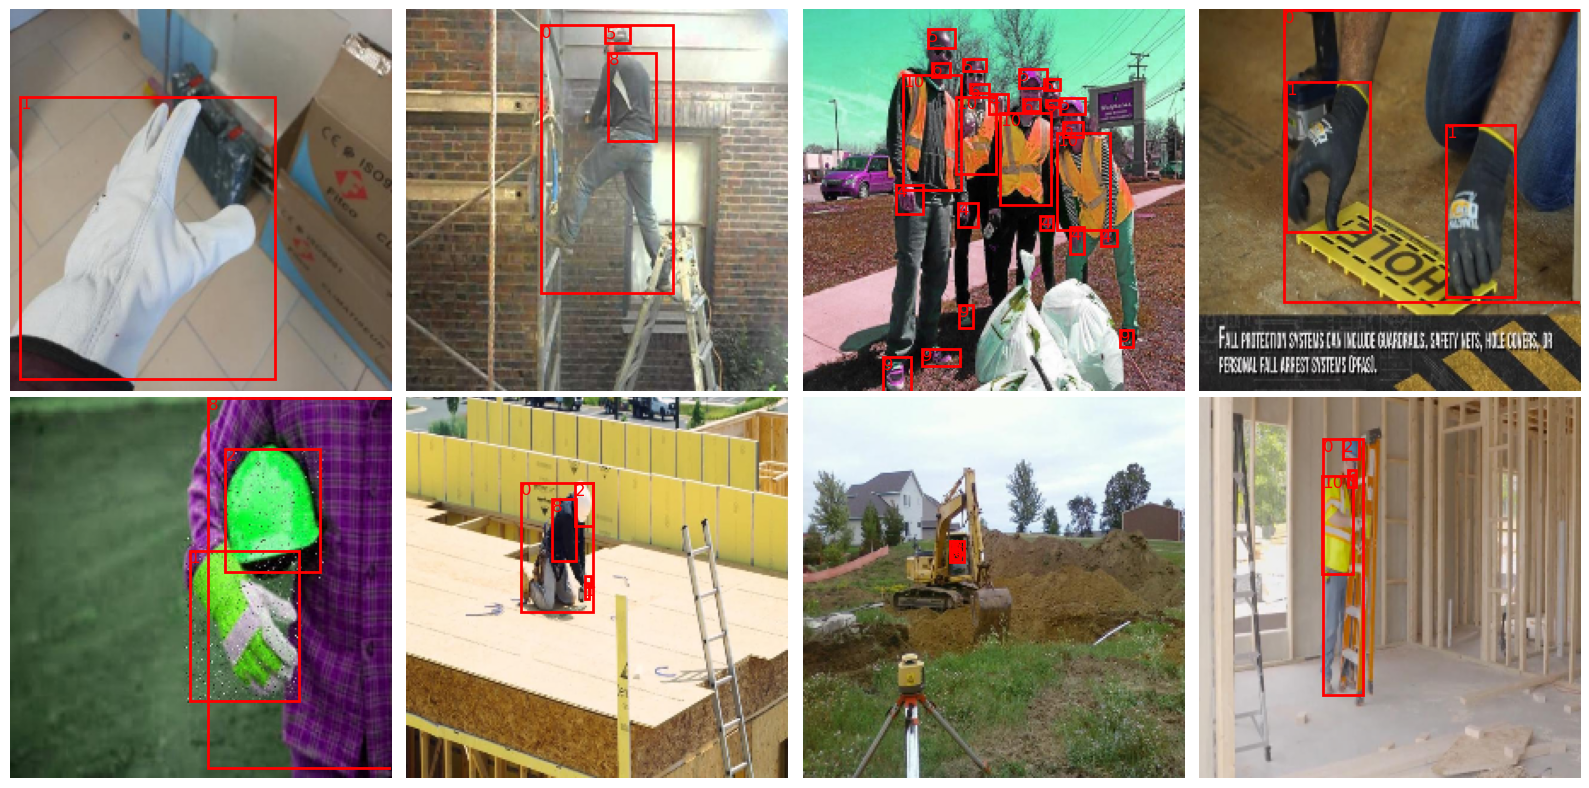

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to plot images with annotations
def plot_images_with_annotations(images, targets, num_images):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(num_images):
        image, target = images[i], targets[i]
        image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        image = (image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])).clamp(0, 1)  # Undo normalization
        
        # Plot image
        axes[i].imshow(image)
        
        # Plot annotations
        boxes = target["boxes"]
        labels = target["labels"]
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
            axes[i].add_patch(bbox)
            axes[i].text(x_min, y_min, str(label.item()), color='r', fontsize=12, ha='left', va='top')
        
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot examples
images, targets = next(iter(train_dataloader))
plot_images_with_annotations(images, targets, num_images=8)


In [17]:
from torch.nn import functional as F

def detection_loss(outputs, targets):
    cls_loss, bbox_loss, rpn_cls_loss, rpn_bbox_loss = outputs
    
    # Classification loss
    cls_targets = [t['labels'] for t in targets]
    cls_loss = F.cross_entropy(cls_loss, cls_targets)
    
    # Bounding box regression loss
    bbox_targets = [t['boxes'] for t in targets]
    bbox_loss = F.smooth_l1_loss(bbox_loss, bbox_targets)
    
    # RPN classification loss
    rpn_cls_targets = [t['rpn_cls_targets'] for t in targets]
    rpn_cls_loss = F.cross_entropy(rpn_cls_loss, rpn_cls_targets)
    
    # RPN bounding box regression loss
    rpn_bbox_targets = [t['rpn_bbox_targets'] for t in targets]
    rpn_bbox_loss = F.smooth_l1_loss(rpn_bbox_loss, rpn_bbox_targets)
    
    return cls_loss + bbox_loss + rpn_cls_loss + rpn_bbox_loss

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define your model
#model = YourObjectDetectionModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model.to(device)

# Define your loss function and optimizer
criterion = detection_loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Iterate over the training data

    for images, targets in tqdm(train_dataloader):  
        images = list(image.to(device) for image in images)
        #images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, targets)  # Returns loss_dict

        # Compute the loss
        #loss = criterion(outputs, targets)
        losses = sum(loss for loss in outputs.values())
        losses.backward()
        optimizer.step()
        #optimizer.zero_grad()
        
        running_loss += losses.item()
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    # Don't track gradients during validation
    with torch.no_grad():
        # Iterate over the validation data
        for images, targets in tqdm(val_dataloader):
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    # Compute and print the average loss for this epoch
    train_loss = running_loss / len(train_dataloader)
    val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'object_detection_model.pth')

  0%|                                                                                                                                                       | 0/2 [01:08<?, ?it/s]


ValueError: too many values to unpack (expected 4)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model.to(device)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

         # Forward pass
        outputs = model(images)

        loss_dict = criterion(outputs, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
    
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Validation loop
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, targets in val_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        outputs = model(images)
        
        # Compute metrics
        # For example, you can compute accuracy for classification tasks
        # Or mAP for object detection tasks
        
        # Update total_correct and total_samples based on your metrics
        
#print(f"Validation Accuracy: {100 * total_correct / total_samples:.2f}%")
